# Training ANN potentials

This notebook demonstrates the training of neural-network based ML potentials.  Note that the data set used here is very small and meant for demonstration only; the resulting MLIP cannot be expected to be good.

**Note: Training requires the ænet binaries to be correctly installed and configured.**

## 1. Featurization of the data set

Featurization with the AUC method is already demonstrated in a separate notebook.  Here, we follow the same approach for a small data set of TiO$_2$ structures that are in ænet's extended XSF format (with energy and force labels).

In [2]:
import glob
from aenet.featurize import AenetAUCFeaturizer

# the AUC featurizer uses the Chebyshev method (Artrith 2017)
fzer = AenetAUCFeaturizer(['Ti', 'O'],
                          rad_cutoff=6.0, rad_order=10, 
                          ang_cutoff=4.0, ang_order=3)

# aenet's generate.x will be run in the specified subdirectory ('run').
# If no work directory is given, a temporary directory is created and
# removed after completion.
fzer.run_aenet_generate(glob.glob("./xsf-TiO2/*.xsf"), 
                        atomic_energies={
                            'O': -432.503149303,
                            'Ti': -1604.604515075},
                        workdir='run')

## 2. Training

Once the featurization has completed, the training can be run in the same work directory.  The available options and training methods are detailed in the documentation.

**Note: The L-BFGS-B method is currently not suppported on macOS, since it relies on legacy Fortran code that is not compatible with the Apple Accelerate framework for BLAS/LAPACK.**

**Note also: MPI parallelization is currently also only supported on Linux.**

In [3]:
from aenet.mlip import ANNPotential, TrainingConfig, Adam

# The ANN architecture only needs to define the hidden layers, 
# as in the usual `train.in` input format.
arch = {
    'Ti': [(10, 'gelu'), (10, 'gelu')],
    'O': [(10, 'gelu'), (10, 'gelu')]
}

mlp = ANNPotential(arch)

# Training run over 100 epochs with the Adam method
config = TrainingConfig(
    iterations=100,
    method=Adam(mu=0.001, batchsize=8, samplesize=100),
    sampling='random',
    max_energy=1.0,
    save_energies=True,
    testpercent=10
)

# Note that we use the same `workdir` as for the featurization.  
# When using a different directory, the path to the training set
# file needs to be specified.
mlp.train(config=config, workdir='run')

# On Linux, MPI parallelization is supported as long as the 
# `train.x` executable was compiled with MPI support.
# mlp.train(config=config, workdir='run', num_processes=32)

Training: 100%|███████████████████████████████| 100/100 [00:20<00:00,  4.99it/s]


## 3. Inspection of the results

Once the training has completed, the results can be inspected with the `TrainOutput` class.

In [4]:
from aenet.io.train import TrainOutput
to = TrainOutput('train.out')
print(to)

Training statistics:
  final_MAE_train: 0.07636581
  final_RMSE_train: 0.1057214
  final_MAE_test: 0.1110751
  final_RMSE_test: 0.1365512
  min_RMSE_test: 0.1249659
  epoch_min_RMSE_test: 91



Generate a plot of the train/validation set RMSE:

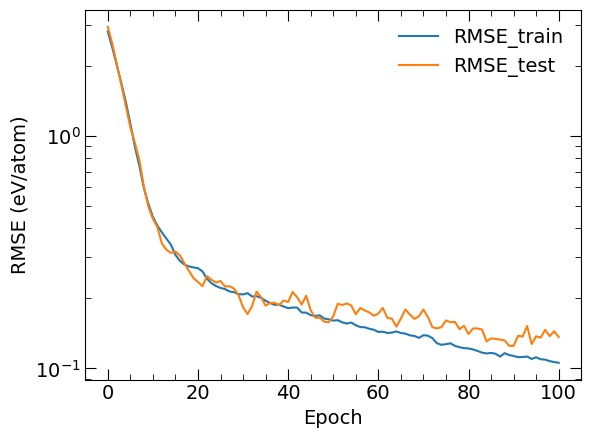

In [5]:
to.plot_training_errors()

If the structure energies have been saved (activated with `save_energies=True` in the above training config), a parity plot can be generated with:

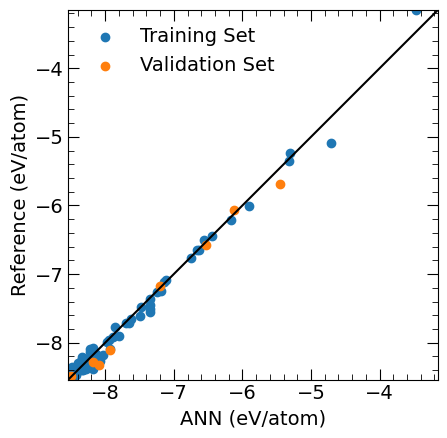

In [6]:
from aenet.io.train import Energies
E = Energies('./energies.train.0', './energies.test.0')
E.plot_correlation()